<a href="https://colab.research.google.com/github/klaudijahristova/Stock_Analysis/blob/main/Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This project involves market prediction using historical stock data and LSTM models, which aligns with the "Market Prediction" project idea mentioned in the list.

Curriculum Topics:
- OOP (Object-Oriented Programming): The project has been refactored to use a class StockAnalysis to encapsulate all functionalities related to stock market analysis.
- Requests, Modules: The project uses external libraries such as yfinance, pandas_datareader, pandas, numpy, matplotlib, seaborn, and keras. The yfinance and pandas_datareader modules are used to fetch stock market data.

In [ ]:
import pandas as pd #data manipulation and analysis
import numpy as np #numerical computations
import matplotlib.pyplot as plt # plotting graphs
import seaborn as sns # statistical data visualization
from pandas_datareader import data as pdr #to fetch data from Yahoo Finance
import yfinance as yf # reliable fetching of stock data
from datetime import datetime #handling date and time
from sklearn.preprocessing import MinMaxScaler # for normalizing data
from keras.models import Sequential
from keras.layers import Dense, LSTM  # building neural networks

sns.set_style('whitegrid')
yf.pdr_override() #  It overrides the pandas_datareader get_data_yahoo method with yfinance's method.
#This is useful because pandas_datareader had issues with Yahoo Finance's changes, and yfinance offers a more reliable alternative.

class StockAnalysis:
    def __init__(self, stock_list, start, end):
        self.stock_list = stock_list
        self.start = start
        self.end = end
        self.company_data = self._get_data()

    def _get_data(self):
        company_data = {}
        for stock in self.stock_list:
            company_data[stock] = yf.download(stock, self.start, self.end)
            company_data[stock]["company_name"] = stock
        return company_data

    def _concat_data(self):
        return pd.concat(self.company_data.values(), axis=0)

    def plot_closing_price(self):
        plt.figure(figsize=(15, 10))
        plt.subplots_adjust(top=1.25, bottom=1.2)
        for i, (company, data) in enumerate(self.company_data.items(), 1):
            plt.subplot(2, 2, i)
            data['Adj Close'].plot()
            plt.ylabel('Adj Close')
            plt.xlabel(None)
            plt.title(f"Closing Price of {company}")
        plt.tight_layout()
        plt.show()

    def plot_volume(self):
        plt.figure(figsize=(15, 10))
        plt.subplots_adjust(top=1.25, bottom=1.2)
        for i, (company, data) in enumerate(self.company_data.items(), 1):
            plt.subplot(2, 2, i)
            data['Volume'].plot()
            plt.ylabel('Volume')
            plt.xlabel(None)
            plt.title(f"Sales Volume for {company}")
        plt.tight_layout()
        plt.show()

    def calculate_moving_average(self, ma_days):
        for ma in ma_days:
            for company, data in self.company_data.items():
                column_name = f"MA for {ma} days"
                data[column_name] = data['Adj Close'].rolling(ma).mean()

    def plot_moving_average(self, ma_days):
        self.calculate_moving_average(ma_days)
        fig, axes = plt.subplots(nrows=2, ncols=2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
        for i, (company, data) in enumerate(self.company_data.items(), 1):
            data[['Adj Close'] + [f"MA for {ma} days" for ma in ma_days]].plot(ax=axes[(i-1)//2, (i-1)%2])
            axes[(i-1)//2, (i-1)%2].set_title(company)
        fig.tight_layout()
        plt.show()

    def calculate_daily_return(self):
        for data in self.company_data.values():
            data['Daily Return'] = data['Adj Close'].pct_change()

    def plot_daily_return(self):
        self.calculate_daily_return()
        fig, axes = plt.subplots(nrows=2, ncols=2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
        for i, (company, data) in enumerate(self.company_data.items(), 1):
            data['Daily Return'].plot(ax=axes[(i-1)//2, (i-1)%2], legend=True, linestyle='--', marker='o')
            axes[(i-1)//2, (i-1)%2].set_title(company)
        fig.tight_layout()
        plt.show()

    def plot_daily_return_histogram(self):
        self.calculate_daily_return()
        plt.figure(figsize=(12, 9))
        for i, (company, data) in enumerate(self.company_data.items(), 1):
            plt.subplot(2, 2, i)
            data['Daily Return'].hist(bins=50)
            plt.xlabel('Daily Return')
            plt.ylabel('Counts')
            plt.title(company)
        plt.tight_layout()
        plt.show()

    def plot_correlation(self):
        closing_df = pdr.get_data_yahoo(self.stock_list, start=self.start, end=self.end)['Adj Close']
        tech_rets = closing_df.pct_change()

        sns.pairplot(tech_rets, kind='reg')
        plt.show()

        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
        plt.title('Correlation of stock return')

        plt.subplot(2, 2, 2)
        sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
        plt.title('Correlation of stock closing price')
        plt.show()

    def plot_risk_return(self):
        closing_df = pdr.get_data_yahoo(self.stock_list, start=self.start, end=self.end)['Adj Close']
        tech_rets = closing_df.pct_change()
        rets = tech_rets.dropna()
        area = np.pi * 20

        plt.figure(figsize=(10, 8))
        plt.scatter(rets.mean(), rets.std(), s=area)
        plt.xlabel('Expected return')
        plt.ylabel('Risk')

        for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
            plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                         arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
        plt.show()

    def predict_stock_price(self, stock, train_size=0.95):
        df = pdr.get_data_yahoo(stock, start='2012-01-01', end=self.end)
        data = df.filter(['Close'])
        dataset = data.values
        training_data_len = int(np.ceil(len(dataset) * train_size))

        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)

        train_data = scaled_data[0:int(training_data_len), :]
        x_train = []
        y_train = []

        for i in range(60, len(train_data)):
            x_train.append(train_data[i-60:i, 0])
            y_train.append(train_data[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, batch_size=1, epochs=1)

        test_data = scaled_data[training_data_len - 60:, :]
        x_test = []
        y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])

        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

        train = data[:training_data_len]
        valid = data[training_data_len:]
        valid['Predictions'] = predictions

        plt.figure(figsize=(16, 6))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()

        return rmse, valid

In [ ]:
# Initialize the StockAnalysis object
stock_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
analysis = StockAnalysis(stock_list, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Perform analyses

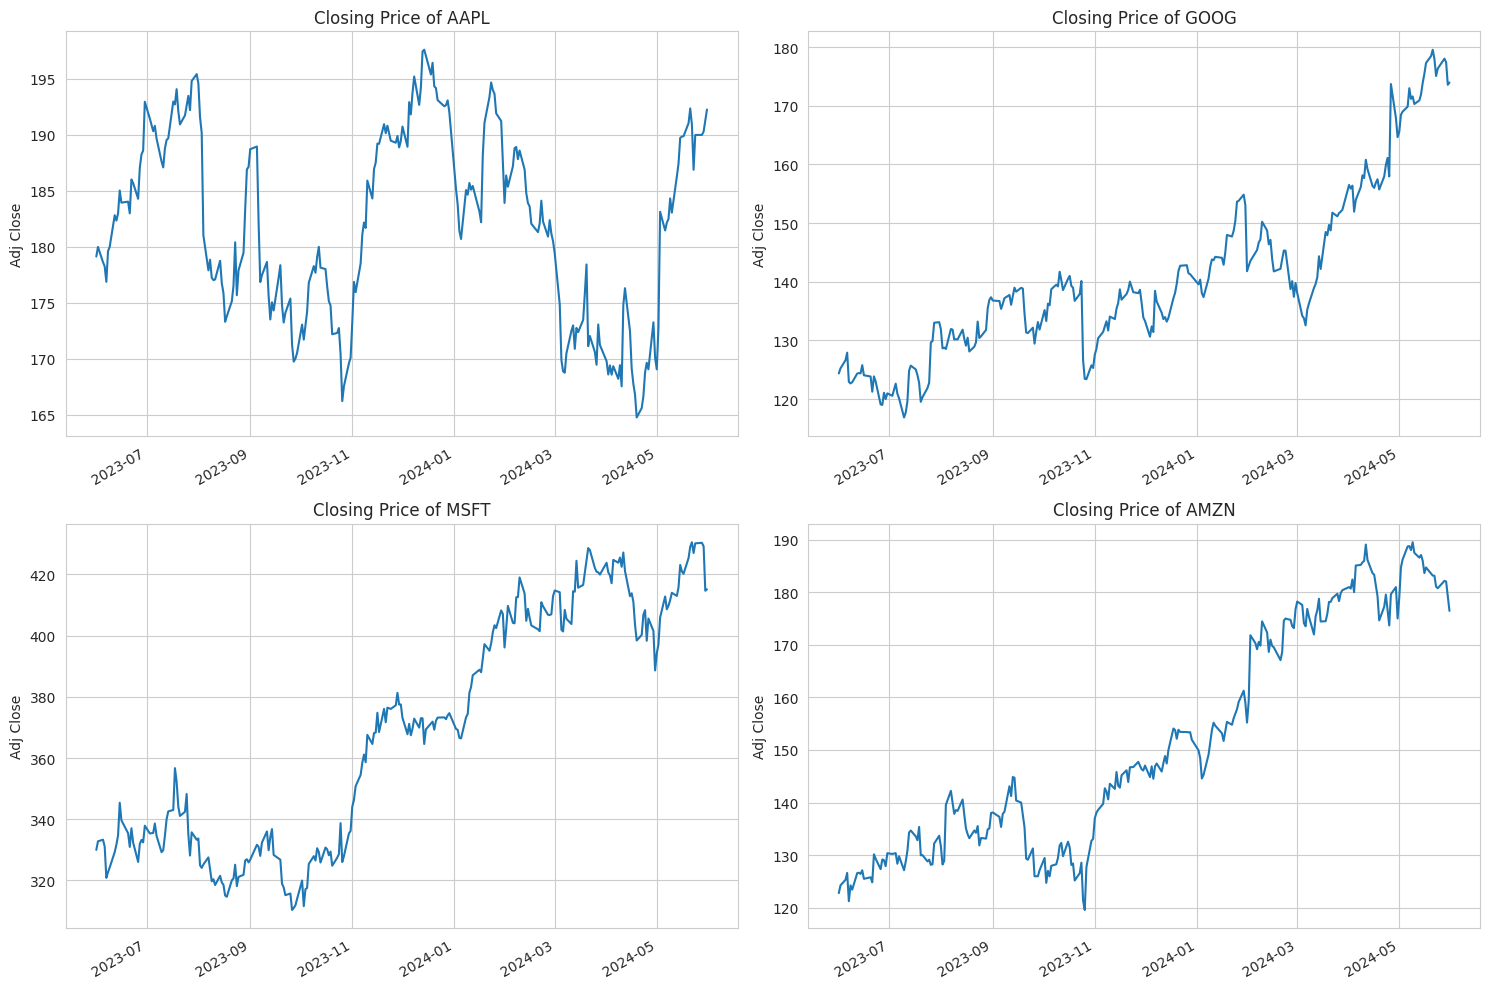

In [ ]:
analysis.plot_closing_price()

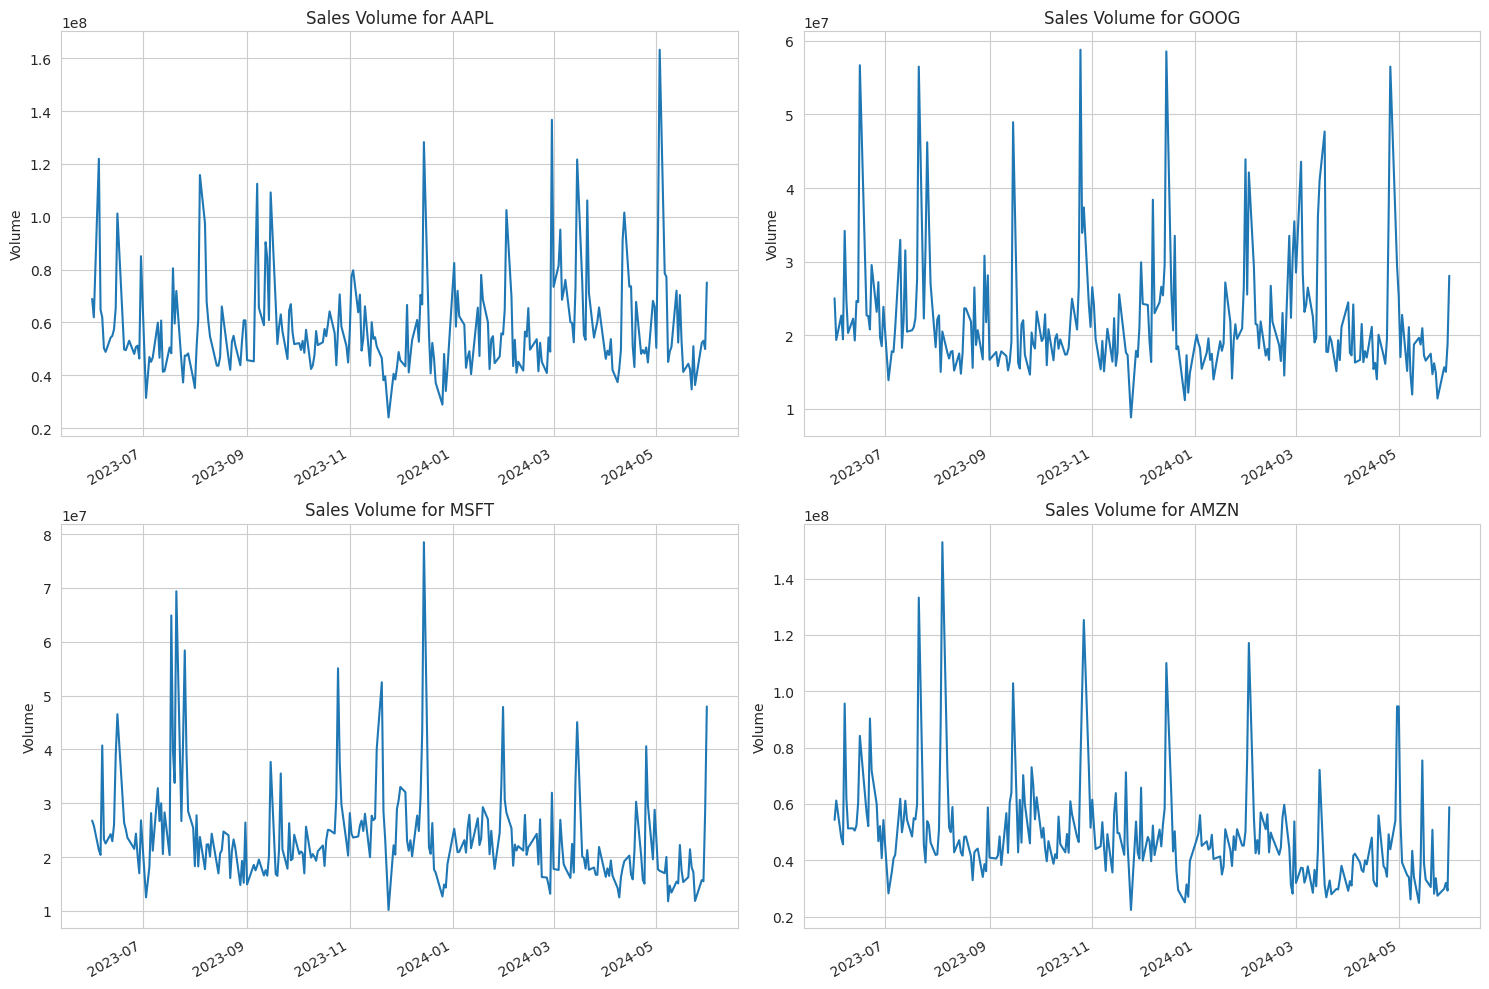

In [ ]:
analysis.plot_volume() # number of shares traded during a specific period

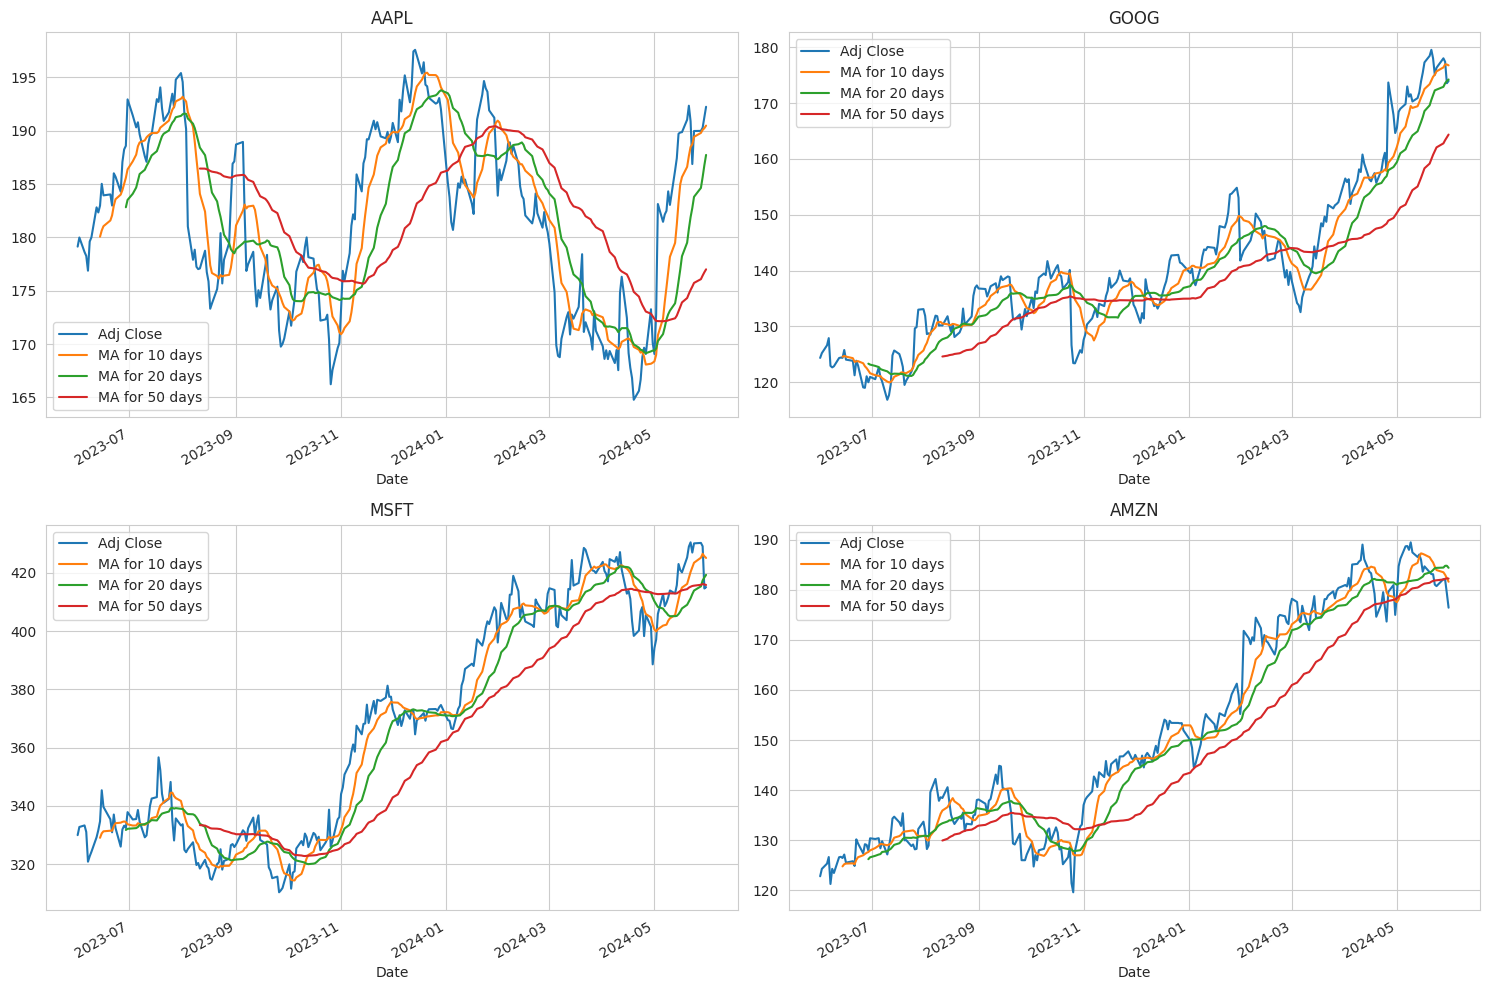

In [ ]:
analysis.plot_moving_average([10, 20, 50]) #averaging the closing prices over a specific number of periods

### Daily return

Purpose:

- Daily returns are used to assess the day-to-day performance and volatility of a stock.
They help in understanding how much a stock's price can fluctuate within a single trading day.

Usage in Analysis:

- Daily returns are used in various financial analyses, including risk assessment, portfolio management, and performance evaluation.
They are also used to compute other metrics like average returns, standard deviation (volatility), and correlations between stocks.

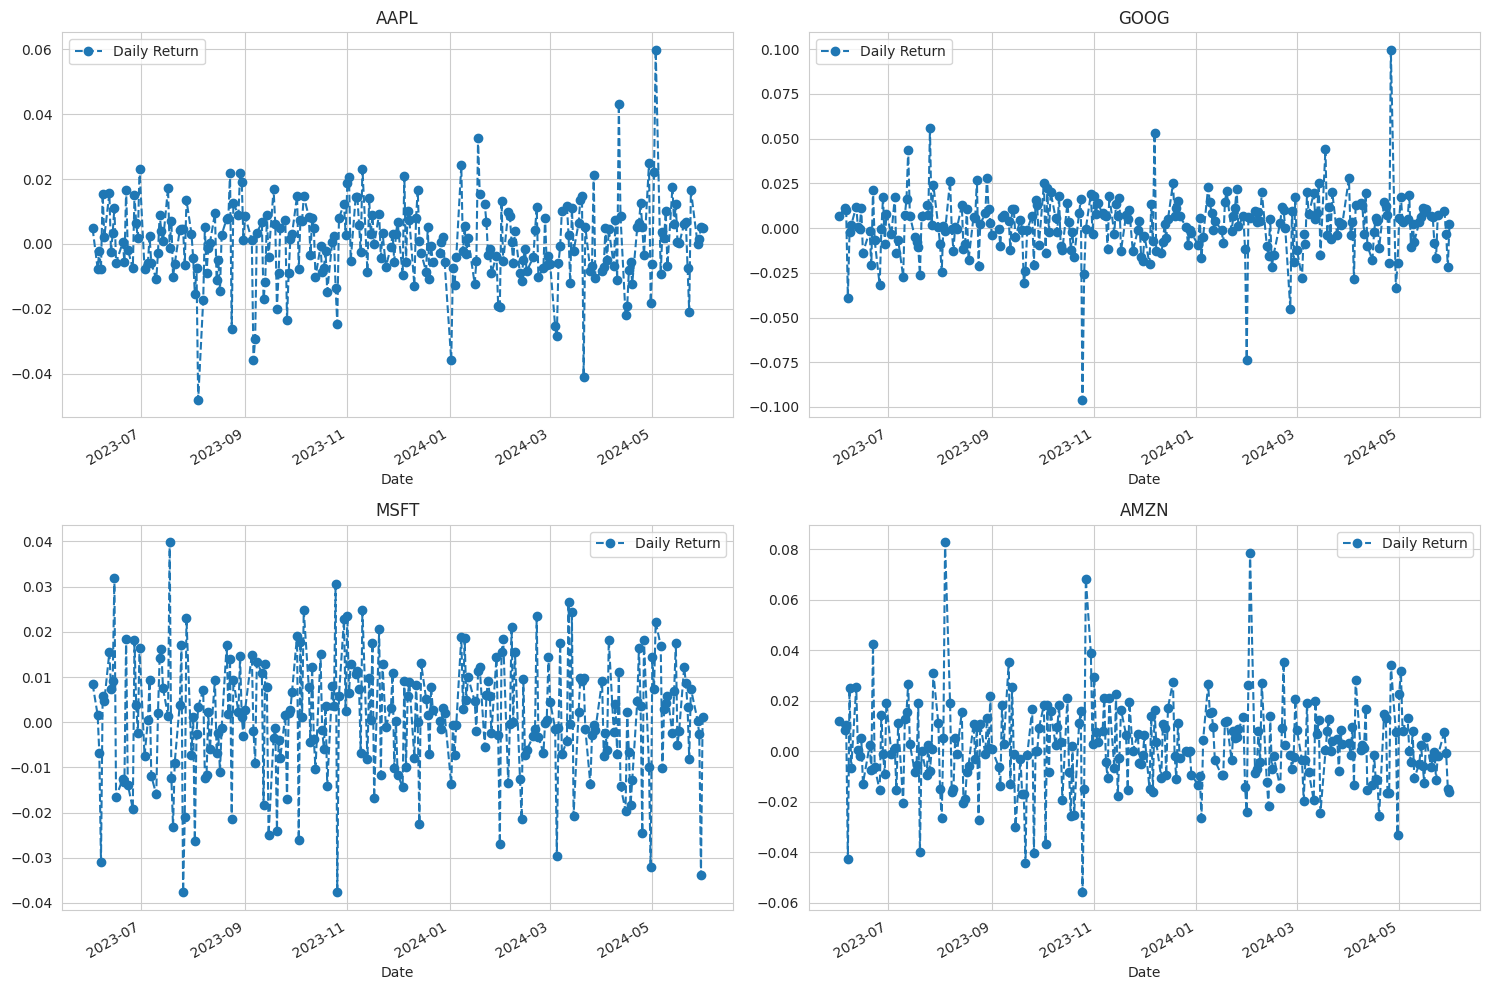

In [ ]:
analysis.plot_daily_return()

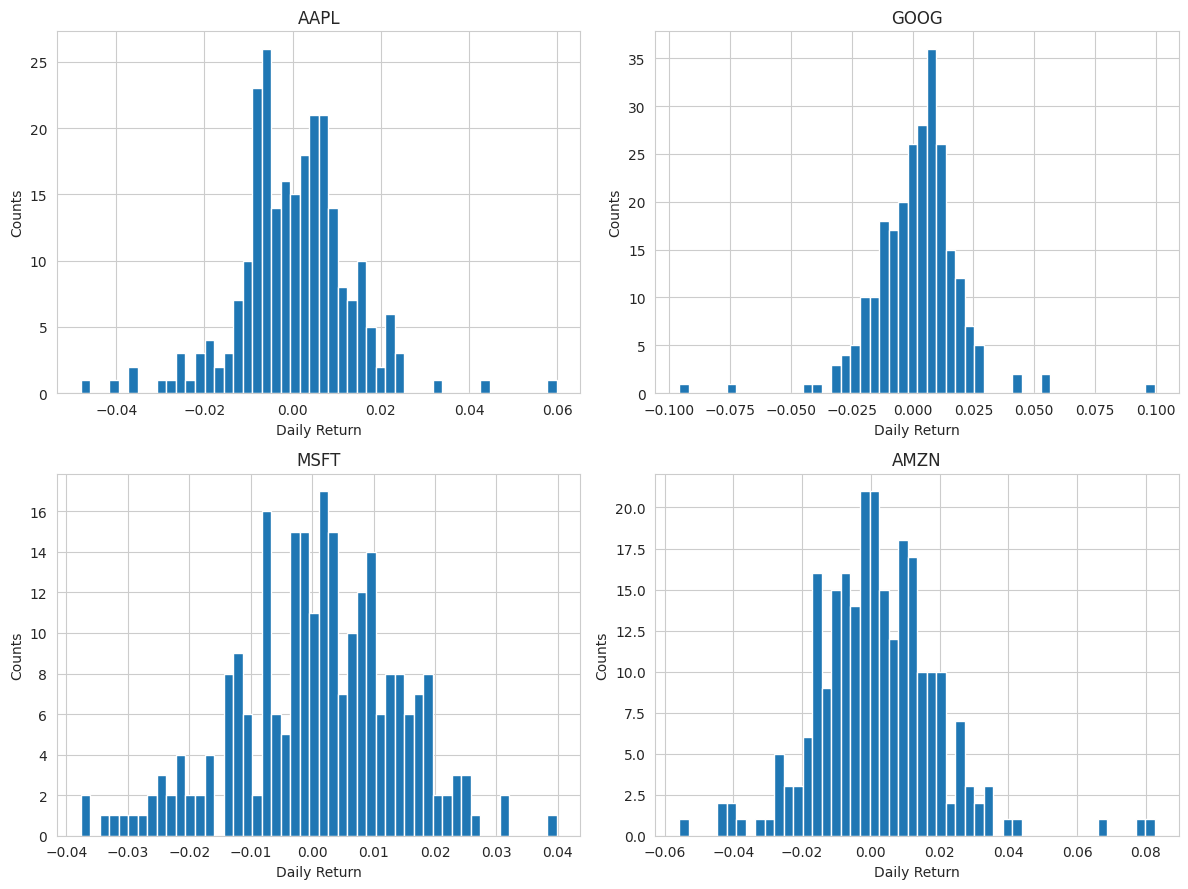

In [ ]:
analysis.plot_daily_return_histogram()

[*********************100%%**********************]  4 of 4 completed


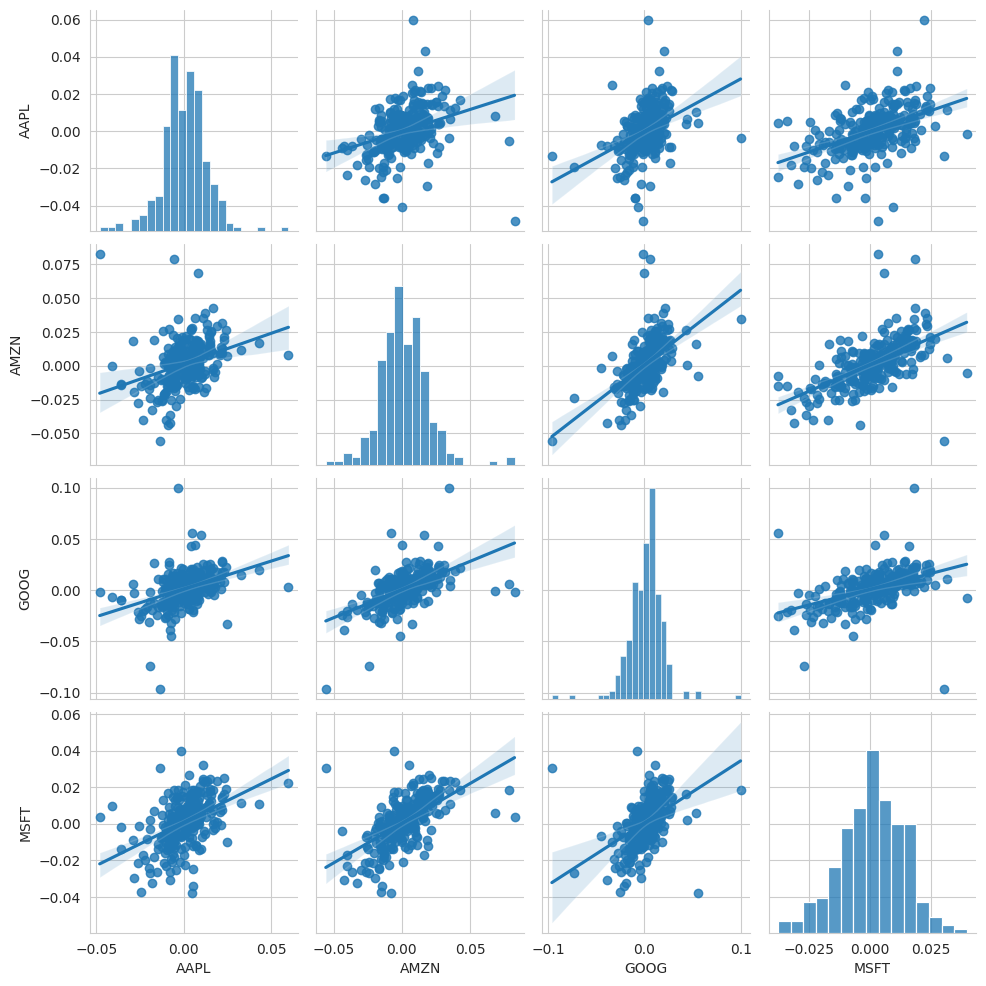

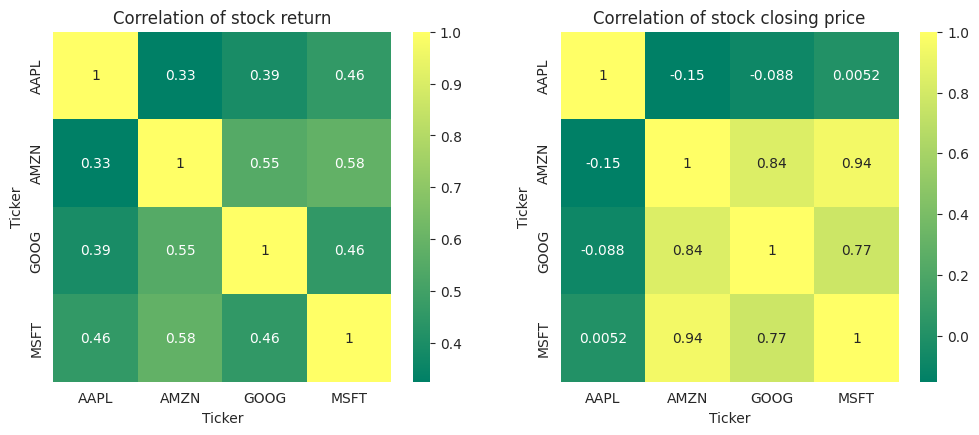

In [ ]:
analysis.plot_correlation()

### Risk-Return Tradeoff:

This principle states that potential return rises with an increase in risk. Investors need to balance their desire for the lowest possible risk with the highest possible returns.

[*********************100%%**********************]  4 of 4 completed


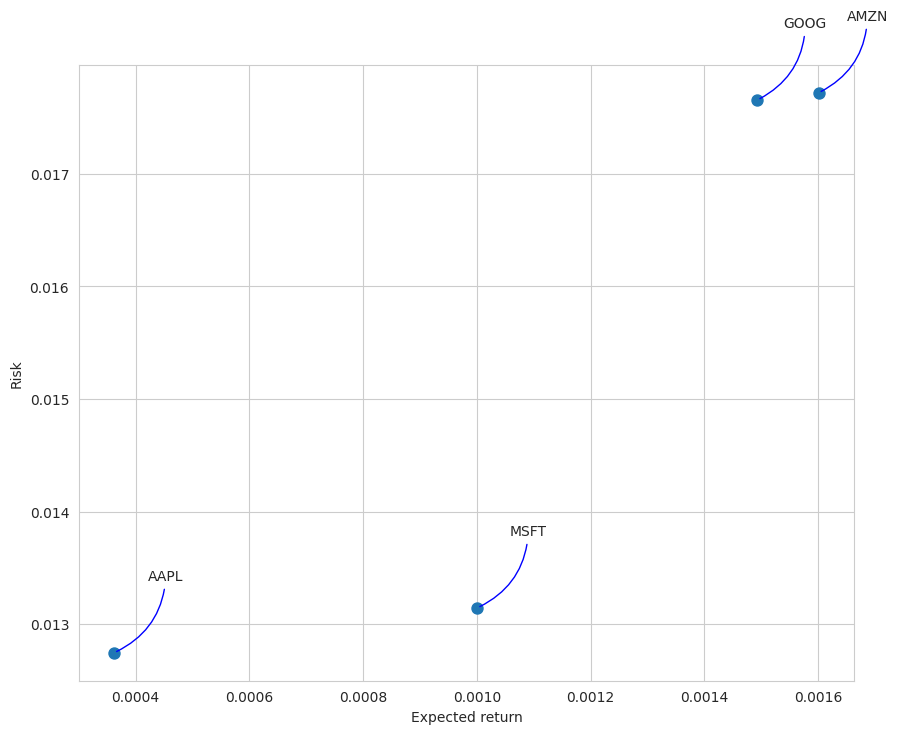

In [ ]:
analysis.plot_risk_return()

[*********************100%%**********************]  1 of 1 completed


5/5 [==============================] - 1s 33ms/step


<ipython-input-5-ede25e5dc46f>:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


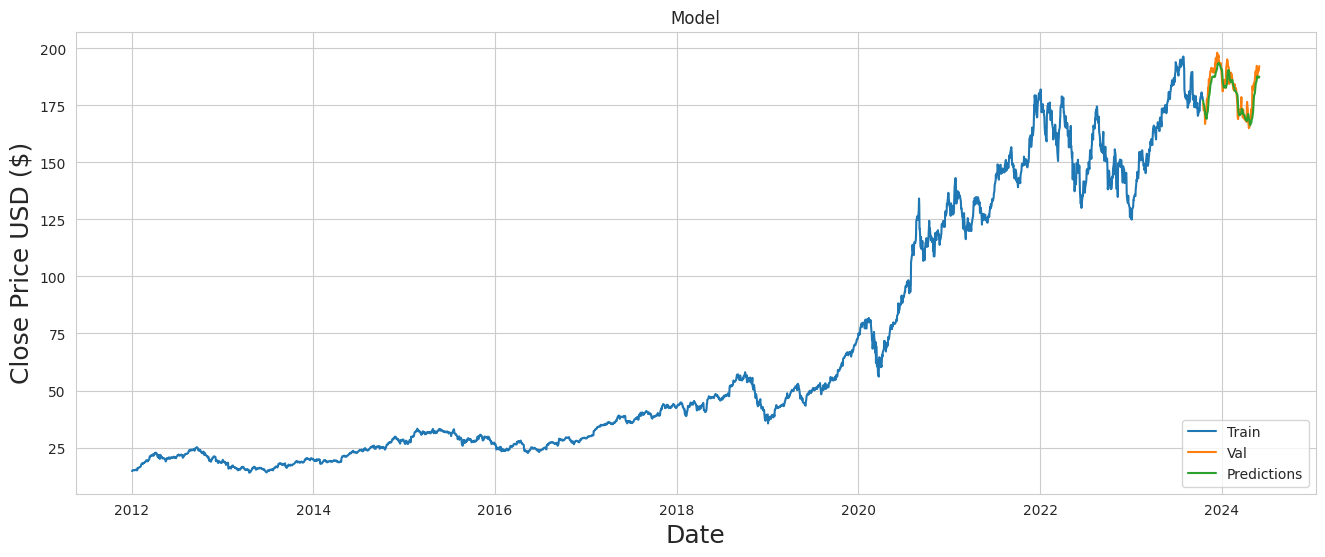

In [ ]:
# Predict stock price
rmse, valid = analysis.predict_stock_price('AAPL')

In [ ]:
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 4.293885963367259


In [ ]:
valid.head(30)

,Close,Predictions
Date,,
2023-10-18,175.839996,177.132568
2023-10-19,175.460007,176.517090
2023-10-20,172.880005,175.826828
2023-10-23,173.000000,174.790146
2023-10-24,173.440002,173.846893
2023-10-25,171.100006,173.182877
2023-10-26,166.889999,172.348663
2023-10-27,168.220001,170.899551
2023-10-30,170.289993,169.724228


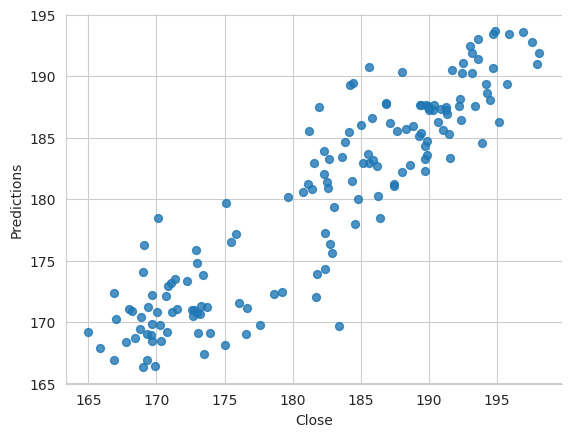

In [ ]:
valid.plot(kind='scatter', x='Close', y='Predictions', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)